## Objective:
- Analysis and results of pricing test
- Understand how user behavior has changed
- Suggest changes to length of the test (shorter, longer, same length?)

In [1]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the raw datasets

# Import the test data
test_df = pd.read_csv('test_results.csv')

# Import the user data
user_df = pd.read_csv('user_table.csv')

In [3]:
# Check the info of the test data
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [4]:
# Check the info of the test data
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [5]:
# Count the number of unique values
test_df.nunique()

user_id             316800
timestamp           140931
source                  12
device                   2
operative_system         6
test                     2
price                    2
converted                2
dtype: int64

In [6]:
# Count the number of unique values
user_df.nunique()

user_id    275616
city          923
country         1
lat           713
long          830
dtype: int64

In [7]:
# Determine the single country entry
user_df['country'].unique()

array(['USA'], dtype=object)

In [8]:
# Display the head of the test dataset
test_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [9]:
# # Convert the timestamp column to a datetime object
# test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], format='%Y-%m-%d %H:%M')

There appear to be irregular time values (ex. 2015-04-24 12:60:46). Since I don't particular care about the time of day that the activity was on, I will extract only the date and convert result to a datetime column.

In [10]:
# Extract only the dates from the timestamp column
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: x.split(' ')[0])

# Convert the timestamp column to a datetime object
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

In [11]:
# Make sure the unique value are as expected
for col in ['source', 'device', 'operative_system', 'test', 'price', 'converted']:
    print(test_df[col].unique())

['ads_facebook' 'seo-google' 'ads-bing' 'direct_traffic' 'ads-google'
 'seo_facebook' 'friend_referral' 'ads_other' 'ads-yahoo' 'seo-yahoo'
 'seo-bing' 'seo-other']
['mobile' 'web']
['iOS' 'android' 'mac' 'windows' 'other' 'linux']
[0 1]
[39 59]
[0 1]


In [12]:
# All test=1 should be price=59. Make sure that is true
test_df[(test_df['test'] == 1) & (test_df['price'] == 39)].shape

(155, 8)

In [13]:
# What about the opposite condition?
test_df[(test_df['test'] == 0) & (test_df['price'] == 59)].shape

(210, 8)

In [14]:
print ('First Entry: {}'.format(test_df['timestamp'].min()))
print ('Last Entry: {}'.format(test_df['timestamp'].max()))

First Entry: 2015-03-02 00:00:00
Last Entry: 2015-05-31 00:00:00


Notes:
- user_id is a unique identifier for both the test and user datasets
- All entries are contained within a single country (USA).
    - I will remove the country column in the user data
- User (lat,long) should correspond directly to the described city.
    - I will remove the lat and long columns in the user data
- test and price from the test dataset should correspond to each other. However, there appear to be 365 entries (~0.115%) where the values are mixed up.
    - I will remove this mismatched entries from the data
- The pricing test occured over March, April, and May (3 months total / 1 quarter).

Let's start with displaying the results of the pricing analysis.
- Note that the test distribtion is 66% control, 33% test.

In [15]:
# Remove the mismatched test data
cleaned_test = test_df[((test_df['test'] == 1) & (test_df['price'] == 59)) | 
                      ((test_df['test'] == 0) & (test_df['price'] == 39))].copy()

# Perform a left merge with the user data
cleaned_df = cleaned_test.merge(user_df[['user_id', 'city']], how='left', on='user_id')

# Fill the null city entries with "Unknown"
cleaned_df.fillna('Unknown', inplace=True)

In [16]:
# Make sure no additional entries were lost
assert (len(cleaned_test) + 365) == len(test_df)

In [17]:
# Define a function to create dataframes with grouped variables
def create_df(df, cat):
    '''Create dataframes with desired groupings'''
    group_df = df.groupby(cat).agg({'price': 'mean', 'converted':'mean'})
    
    # Determine the average gain (conversion_rate * price)
    group_df['avg_gain'] = group_df['price'] * group_df['converted']
    
    return group_df

In [18]:
# # Create a dataframe grouped by the test
# test_results = cleaned_df.groupby('test').agg({'price': 'mean', 'converted':'mean'})

# # Determine the average gain (conversion_rate * price)
# test_results['avg_gain'] = test_results['price'] * test_results['converted']

test_results = create_df(cleaned_df, 'test')

# Display the results
test_results

,price,converted,avg_gain
test,,,
0,39,0.019900,0.776083
1,59,0.015555,0.917748


In [19]:
# Calculate the percent change in conversion and avg_gains from control to experimental
perc_conv = (test_results.iloc[0, 1] - test_results.iloc[1,1]) / test_results.iloc[0, 1] * 100
perc_gains = (test_results.iloc[1, 2] - test_results.iloc[0, 2]) / test_results.iloc[0, 2] * 100
print ('''There is a {:.2f}% decrease in conversion rates.
However, there is a {:.2f}% increase in total gains.'''.format(perc_conv, perc_gains))

There is a 21.83% decrease in conversion rates.
However, there is a 18.25% increase in total gains.


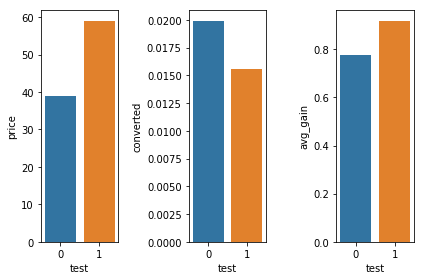

In [20]:
fig, ax = plt.subplots(ncols=3)
for col in range(len(test_results.columns)):
    sns.barplot(x=test_results.index, y=test_results.iloc[:, col], ax=ax[col])
    plt.tight_layout()

### Summary:
- Increased prices does cause a decrease in conversion rates (less people are buying the product).
- However, the drop in conversion rate is compensated for by the 33.9% increase in price to result in a positive net profit. 

Before I study the resutls in more depth, I will construct some new variables from the timestamp columns, particularly weekofyear and weekday.

In [21]:
# Create the weekofyear column
cleaned_df['weekofyear'] = cleaned_df['timestamp'].dt.weekofyear

# Create the weekday column
cleaned_df['weekday'] = cleaned_df['timestamp'].dt.weekday

In [22]:
# Let's see the conversion rates in terms of device
device_df = create_df(cleaned_df, ['device', 'test'])

# Reset the index for plotting
device_df.reset_index(inplace=True)

# Display the results
device_df

,device,test,price,converted,avg_gain
0,mobile,0,39,0.019872,0.775017
1,mobile,1,59,0.016146,0.952624
2,web,0,39,0.019940,0.777645
3,web,1,59,0.014744,0.869888


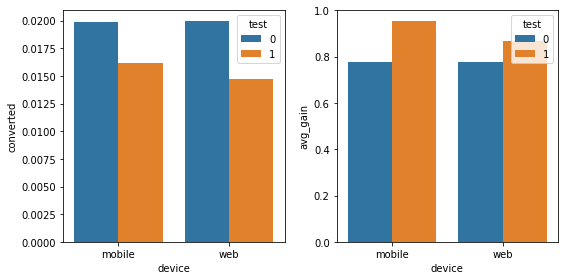

In [23]:
# Create barplots for the columns of interest
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

# Define the columns of interest
CoI = ['converted', 'avg_gain']

for col in range(len(CoI)):
    sns.barplot(x='device', y=device_df[CoI[col]], hue='test', data=device_df, ax=ax[col])
    plt.tight_layout()

Note:
- Mobile has a higher conversion rate than web for the test group (higher prices)
    - However, for the control group, they have equal conversion rates.

In [24]:
# Define a function for creating barplots
def create_plots(df, cat):
    '''Create barplots for the specified dataframe'''
    # Define the subplots
    fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
    
    # Create the barplots
    for col in range(len(CoI)):
        sns.barplot(x=cat, y=df[CoI[col]], hue='test', data=df, ax=ax[col])
        ax[col].set_xticklabels(labels=df[cat].unique(), rotation=45)
        plt.tight_layout()

In [25]:
# Let's see the conversion rates in terms of source
source_df = create_df(cleaned_df, ['source', 'test'])

# Reset the index for plotting
source_df.reset_index(inplace=True)

# Display the results
source_df

,source,test,price,converted,avg_gain
0,ads-bing,0,39,0.013371,0.521462
1,ads-bing,1,59,0.009579,0.565175
2,ads-google,0,39,0.022566,0.880063
3,ads-google,1,59,0.019631,1.158208
4,ads-yahoo,0,39,0.016833,0.656484
5,ads-yahoo,1,59,0.011236,0.662921
6,ads_facebook,0,39,0.023654,0.922522
7,ads_facebook,1,59,0.016856,0.994502
8,ads_other,0,39,0.015424,0.601527
9,ads_other,1,59,0.012394,0.731220


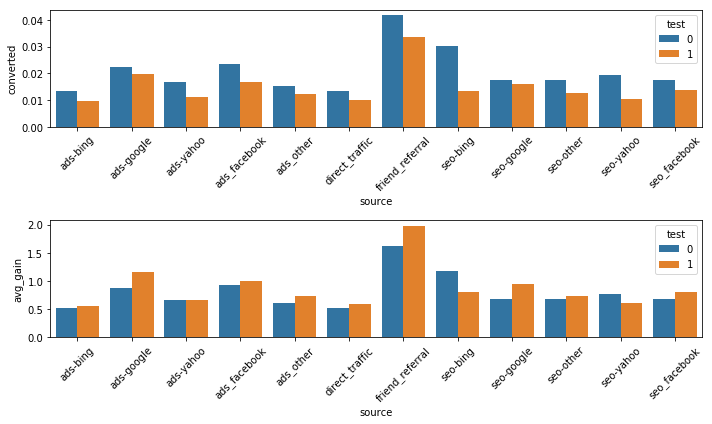

In [26]:
create_plots(source_df, 'source')

In [27]:
# Define a function to return only values that performed above the mean
def above_mean(df):
    '''Return a dataframe with the dataframes that performed above the mean'''
    control_grp = df[(df['test'] == 0) & (df['converted'] > 0.0199)]
    test_grp = df[(df['test'] == 1) & (df['converted'] > 0.01555)]
    above_df = pd.concat([control_grp, test_grp])
    return above_df

In [28]:
# Print the above mean values
above_mean(source_df)

,source,test,price,converted,avg_gain
2,ads-google,0,39,0.022566,0.880063
6,ads_facebook,0,39,0.023654,0.922522
12,friend_referral,0,39,0.041689,1.625867
14,seo-bing,0,39,0.030098,1.173815
3,ads-google,1,59,0.019631,1.158208
7,ads_facebook,1,59,0.016856,0.994502
13,friend_referral,1,59,0.033479,1.975255
17,seo-google,1,59,0.016005,0.944293


Notes:
    - Ads-google, Ads-Facebook, Friend-Referral, SEO-Bing all perform above the mean.
    - Friend_referral performs exceptionally well (2x higher conversion rates)
    - SEO-Bing has a very high conversion rate with the control group (50% higher than mean)
    - Ads-yahoo and SEO-yahoo both have higher conversion rates with the control group.

In [29]:
# Let's see the conversion rates in terms of source
os_df = create_df(cleaned_df, ['operative_system', 'test'])

# Reset the index for plotting
os_df.reset_index(inplace=True)

# Display the results
os_df

,operative_system,test,price,converted,avg_gain
0,android,0,39,0.016336,0.637088
1,android,1,59,0.012363,0.729405
2,iOS,0,39,0.023595,0.920201
3,iOS,1,59,0.019994,1.179648
4,linux,0,39,0.015426,0.601633
5,linux,1,59,0.000000,0.000000
6,mac,0,39,0.025451,0.992597
7,mac,1,59,0.021240,1.253157
8,other,0,39,0.014025,0.546990
9,other,1,59,0.011060,0.652563


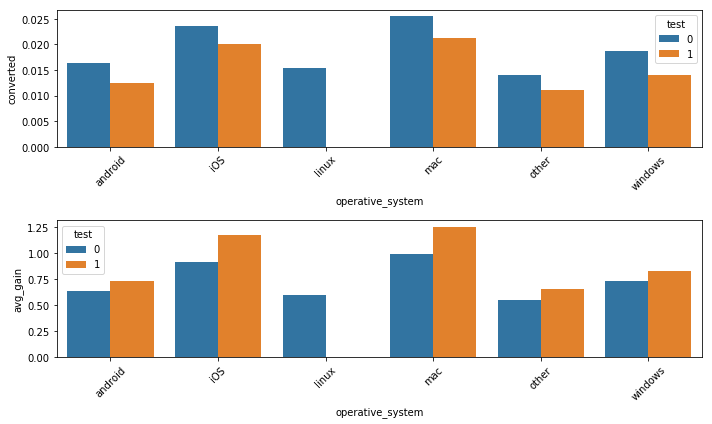

In [30]:
create_plots(os_df, 'operative_system')

In [31]:
# Print the above mean values
above_mean(os_df)

,operative_system,test,price,converted,avg_gain
2,iOS,0,39,0.023595,0.920201
6,mac,0,39,0.025451,0.992597
3,iOS,1,59,0.019994,1.179648
7,mac,1,59,0.021240,1.253157


Note:
- The apple operating systems (iOS and Mac) perform slightly above the mean, but do perform better than the rest of the operating systems.
- There is a 0% conversion rate for the test linux group.

Let's make sure that there are linux entries for the control and test groups.

In [32]:
# Check for the distribution of test and control groups for linux
cleaned_df.groupby(['operative_system', 'test'])['user_id'].count()

operative_system  test
android           0       48177
                  1       26693
iOS               0       61793
                  1       33560
linux             0        2204
                  1        1926
mac               0       16345
                  1        8710
other             0       10481
                  1        5696
windows           0       63517
                  1       37333
Name: user_id, dtype: int64

There appear to be ~2000 entries for both the control and test groups of Linux. However, it is noteworthy that Linux is the only operative system with a control-test split close to equal. The rest of the OS have a 2/1 (66%/33%) split.

In [33]:
# Let's see the conversion rates in terms of source
city_df = create_df(cleaned_df, ['city', 'test'])

# Reset the index for plotting
city_df.reset_index(inplace=True)

In [34]:
# Count the cities that are above the mean
above_mean(city_df)['city'].nunique()

598

In [35]:
# Print the top 10 cities
above_mean(city_df).sort_values('converted', ascending=False).head(10)

,city,test,price,converted,avg_gain
160,Bonita Springs,0,39,0.250000,9.750000
268,Catonsville,0,39,0.250000,9.750000
1113,North Atlanta,1,59,0.250000,14.750000
888,Lehigh Acres,1,59,0.210526,12.421053
290,Chapel Hill,1,59,0.200000,11.800000
1403,Saint Charles,0,39,0.200000,7.800000
1211,Parkway-South Sacramento,0,39,0.181818,7.090909
153,Blue Springs,1,59,0.166667,9.833333
555,Findlay,1,59,0.166667,9.833333
491,Edmonds,1,59,0.142857,8.428571


In [36]:
# show the top 10 cities with the largest sample size
top_10 = cleaned_df['city'].value_counts()[:10].index

city_df.set_index('city', inplace=True)

city_df.loc[top_10]

,test,price,converted,avg_gain
city,,,,
Unknown,0,39,0.020779,0.810397
Unknown,1,59,0.016280,0.960511
New York,0,39,0.018540,0.723051
New York,1,59,0.014849,0.876078
Chicago,0,39,0.014392,0.561273
Chicago,1,59,0.013683,0.807271
Houston,0,39,0.019479,0.759681
Houston,1,59,0.015189,0.896141
San Antonio,0,39,0.020116,0.784521


Notes:
- Of 923 cities, 598 cities performed above the mean, with some cities with the max conversion of 25% (10x higher than mean for control and 16x for test)
- The cities with the largest sample size, on average, has a conversion rate below the mean.

In [37]:
# Let's see the conversion rates in terms of source
week_df = create_df(cleaned_df, ['weekofyear', 'test'])

# Reset the index for plotting
week_df.reset_index(inplace=True)

# Display the results
week_df

,weekofyear,test,price,converted,avg_gain
0,10,0,39,0.021166,0.825489
1,10,1,59,0.017375,1.025122
2,11,0,39,0.017857,0.696429
3,11,1,59,0.015830,0.933963
4,12,0,39,0.019966,0.778661
5,12,1,59,0.016157,0.953249
6,13,0,39,0.019375,0.755627
7,13,1,59,0.015598,0.920255
8,14,0,39,0.020523,0.800396
9,14,1,59,0.014206,0.838128


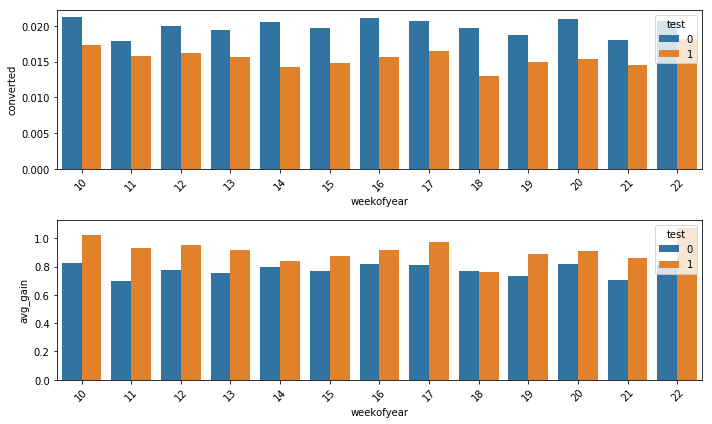

In [38]:
create_plots(week_df, 'weekofyear')

In [39]:
above_mean(week_df)

,weekofyear,test,price,converted,avg_gain
0,10,0,39,0.021166,0.825489
4,12,0,39,0.019966,0.778661
8,14,0,39,0.020523,0.800396
12,16,0,39,0.021064,0.821502
14,17,0,39,0.020735,0.808681
20,20,0,39,0.020945,0.816858
24,22,0,39,0.020736,0.808697
1,10,1,59,0.017375,1.025122
3,11,1,59,0.015830,0.933963
5,12,1,59,0.016157,0.953249


No week single week stood out from the rest. However, in week 18, the test group had a very low conversion rate. This was the only week where the control group had a higher average gain than the test group.

In [40]:
# Let's see the conversion rates in terms of source
day_df = create_df(cleaned_df, ['weekday', 'test'])

# Reset the index for plotting
day_df.reset_index(inplace=True)

# Display the results
day_df

,weekday,test,price,converted,avg_gain
0,0,0,39,0.020243,0.789461
1,0,1,59,0.013988,0.825293
2,1,0,39,0.018259,0.712105
3,1,1,59,0.013621,0.803652
4,2,0,39,0.020805,0.811414
5,2,1,59,0.013423,0.791946
6,3,0,39,0.019935,0.777479
7,3,1,59,0.015789,0.931555
8,4,0,39,0.019918,0.776787
9,4,1,59,0.016124,0.951296


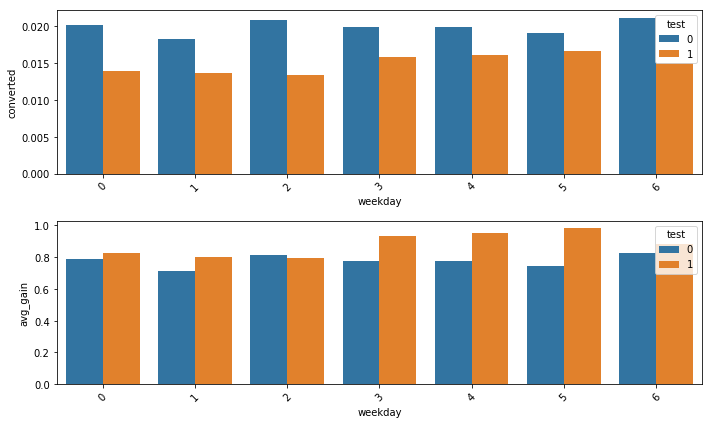

In [41]:
create_plots(day_df, 'weekday')

In [42]:
above_mean(day_df)

,weekday,test,price,converted,avg_gain
0,0,0,39,0.020243,0.789461
4,2,0,39,0.020805,0.811414
6,3,0,39,0.019935,0.777479
8,4,0,39,0.019918,0.776787
12,6,0,39,0.021173,0.825765
7,3,1,59,0.015789,0.931555
9,4,1,59,0.016124,0.951296
11,5,1,59,0.016645,0.982040


Notes:
- No weekday performs far above the rest, but the control group performs much better than the test group Monday through Wednesday. 
- For Monday and Tuesday, the gap in average gain between control and test group is very small. 
- For Wednesday, the control group has a higher average gain than the test group. 
- Increase conversion rate for Thursday through Saturday.

## Conclusion:
- Results of the Price Test:
    - 21.83% decrease in conversion rates.
    - 18.25% increase in total gains.
    -> Increase net profit if price is increased from 39 to 59.
- Larger decline in conversion rates for desktop than for mobile.
- Decline in conversion rates for Ads- and SEO- Yahoo exceed increase in price causing a negative net profit.
- SEO-Bing has the largest drop in conversion rate from control to test (previously second higher conversion rate).
    - Large loss in net profit from SEO-Bing.
- iOs and Mac have the highest conversion rates amongst all operating systems.
    - Linux has 0% conversion rate for the test group despite ~2000 entries.
        - There may be some sort of error in the interface of the site for the test group.
- Over half of the cities performed above the mean, with some cities performing 10x higher than the mean for control and 16x higher for the test.
    - However, the cities with the largest sample size tend to perform below the mean.
- On week 18, the test group performs much lower than the control group. This yields the only week where the control group has a higher conversion rate than the test group.
- On Wednesdays, the control group has a higher net profit than the test group.
- There is an observable increase in conversion rate for the test group from Thursday through Saturday.

### Suggestions:
Regarding the length of this price test, I would personally shorten the length of the test by one month to two months. For the first month, I would keep the experiment as is, but for the second month I would change the split to 33%/66% for control/test to increase profits for the duration of the month while still testing the prices. By the end of the first month (week 13), the difference in net profit is already visible with the higher price yielding more profit. The second month can be used to continue the test, but changing the split would yield increased net profit for that quarter. If the pattern stays constant, then by the end of the second month, it would be safe to completely increase the price from 39 to 59.